# Sobre o Conjunto de Dados

### Modelagem ML para identificar a relação de genomas com os genes ortólogos

Analise do dataset com os outcomes (0 não patógenos e 1 patógeno). 
As variáveis (OG grupos de genes ortólogos) estão nas colunas e nas linhas estão as instâncias (genomas). 
Inicialmente tente descobrir os OG envolvidos na patogênese, os módulos funcionais (os OG que estão atuando em conjunto).

Dicas: A presença do gene é mais importante do que ausências! Ou seja, o(s) gene(s) precisam estar lá para desempenhar a interação com o hospedeiro e a função da patogênese. 
Alguns não patógenos podem ter alguns poucos genes de virulência também
mas é preciso ter a grande maioria deles para ser um patógeno eficiente de importância clínica.

In [1]:
import os
import gzip
import pandas as pd
import numpy as np

In [27]:
with gzip.open("dataset.csv.gz", 'rb') as f:
    df = pd.read_csv(f,sep=',')

In [28]:
df.rename(columns= {"GENOME" :"Genome"}, inplace = True)

In [29]:
df['Target'] = df['Target'].apply(lambda x : 1 if(x == True) else 0)

In [30]:
df.set_index("Genome", inplace = True)

In [31]:
df.head()

,OG0000000,OG0000001,OG0000002,OG0000003,OG0000004,OG0000005,OG0000006,OG0000007,OG0000008,OG0000009,...,OG0033037,OG0033038,OG0033039,OG0033040,OG0033041,OG0033042,OG0033043,OG0033044,OG0033045,Target
Genome,,,,,,,,,,,,,,,,,,,,,
GCF_000010105.1,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
GCF_000010805.1,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
GCF_000014565.1,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
GCF_000164155.2,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,1
GCF_000174835.1,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0


## PRÉ PROCESSAMENTO DOS DADOS 

In [9]:
# PRÉ PROCESSAMENTO DOS DADOS 
from sklearn.feature_selection import mutual_info_regression

In [10]:
dataset_x = df.copy()
dataset_y = dataset_x.pop("Target")

discrete_features = dataset_x.dtypes == int

In [11]:
def make_mi_scores(dataset_x, dataset_y, discrete_features):
    mi_scores = mutual_info_regression(dataset_x, dataset_y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=dataset_x.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

mi_scores = make_mi_scores(dataset_x, dataset_y, discrete_features)
mi_scores[::2]*100  # show a few features with their MI scores

OG0006668    31.066691
OG0005332    29.658605
OG0006674    28.391991
OG0006549    27.849608
OG0005061    27.791942
               ...    
OG0020938     0.000000
OG0020940     0.000000
OG0009807     0.000000
OG0009801     0.000000
OG0009799     0.000000
Name: MI Scores, Length: 16523, dtype: float64

In [13]:
import matplotlib.pyplot as plt 
import plotly.graph_objects as go
import plotly.express as px
import plotly.offline as py
py.init_notebook_mode(connected=True)
import seaborn as sns
import shap
from pandas_profiling import ProfileReport

`import pandas_profiling` is going to be deprecated by April 1st. Please use `import ydata_profiling` instead.


In [32]:
# PLOTANDO AS PRINCIPAIS FEATURES 
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")


plt.figure(dpi=100, figsize=(10, 15))
plot_mi_scores(mi_scores[::2]*100 >= 10.00)

In [25]:
# pegando as variaveis mais influentes com mais de 25%

# [mi_scores[::2]*100 >= 25.00]
for a in [mi_scores[::2]*100 >= 10.00]:
    print (str(a.index))

df_non_target = df.filter(items=list(a.index))

Index(['OG0006668', 'OG0005332', 'OG0006674', 'OG0006549', 'OG0005061',
       'OG0005931', 'OG0000420', 'OG0006515', 'OG0006733', 'OG0006380',
       ...
       'OG0020923', 'OG0009817', 'OG0020928', 'OG0020930', 'OG0020936',
       'OG0020938', 'OG0020940', 'OG0009807', 'OG0009801', 'OG0009799'],
      dtype='object', length=16523)


## Modelo de machine Learning

### Vamos começar a preparar os dados para testar um modelo de classificação

### Separe o conjunto de dados em dois grupos: treino e teste nas proporções de 70% e 30% respectivamente.

* Lembre-se que primeiro vai ser preciso separar as features do target antes de usar o train_test_split. Nosso target é a coluna 'Status'.
* Estamos lidando com dados desbalanceados, então pode ser legal setar o argumento stratify do train_test_split usando a variável target.

In [35]:
# Indicando as variáveis “x” e “y” estamos dizendo que queremos separar estas duas variáveis em dois grupos, sendo que com o parâmetro “test_size = 0.3” 
# determinamos que os dados de teste receberão 30% dos dados, e os dados de treino 70%. Como estamos dividindo duas bases
# como resultado teremos quatro bases, sendo que cada uma será salva na respectiva variável.

from sklearn.model_selection import train_test_split

# Criamos então a variável “y” com os dados da coluna “target”, ou seja, os dados que iremos prever. Criamos também a variável “x” com as demais colunas do dataset, que são as variáveis preditoras.

x = df_non_target
y = df['Target']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.4)

print(x_train.shape, 
      x_test.shape, 
      y_train.shape,
      y_test.shape)

(208, 16523) (140, 16523) (208,) (140,)


## Usando Modelos de Classificação 

In [36]:
# IMPORTANDO SO MODELOS DE CLASSIFICAÇÃO 
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier

# IMPORTANDO AS MÉTRICAS QUE SERÃO UTILIZADA 
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.model_selection import GridSearchCV

## Arvore de Decisão 

In [37]:
# Arvore de decisão  

model_decisiontree = DecisionTreeClassifier()

# training fit 
model_decisiontree.fit(x_train,y_train)

# predict
decisionTreePred = model_decisiontree.predict(x_test)

# acuracy
acc_decisiontree = round(model_decisiontree.score(x_test, y_test)*100,2)

#precision model 
decisionTreePrecision = round(precision_score(y_test, decisionTreePred)*100,2)

# F1 Score
decisionTreeF1_score = round(f1_score(y_test, decisionTreePred)*100,2)

#recall 
decisionTree_Recall = round(recall_score(y_test, decisionTreePred)*100,2)

## Regressão Logistica

In [41]:
model_LogisticRegress = LogisticRegression()

#Fit the model
model_LogisticRegress.fit(x_train,y_train)

# predict
logRegressPred = model_LogisticRegress.predict(x_test)

#Accuracy
acc_logreg = round(model_LogisticRegress.score(x_test, y_test)*100,2)

#precision model 
logRegressPrecision = round(precision_score(y_test, logRegressPred)*100,2)

# F1 Score
logRegressF1_score = round(f1_score(y_test, logRegressPred)*100,2)

#recall 
logRegr_Recall = round(recall_score(y_test, logRegressPred)*100,2)

## Random Forest 

In [50]:
model_randomForest = RandomForestClassifier()

#Fit the model
model_randomForest.fit(x_train,y_train)

# predict
randomForestPred = model_randomForest.predict(x_test)

#Accuracy
acc_randomForest = round(model_randomForest.score(x_test, y_test)*100,2)

#Precisão do Modelo
RandomForestPrecision = round(precision_score(y_test, randomForestPred)*100,2)

# F1 Score
randomForest_F1_score = round(f1_score(y_test, randomForestPred)*100,2)

#recall 
randomForest_Recall = round(recall_score(y_test, randomForestPred)*100,2)

## XGBoost

## Validando os modelos de Classificação 

In [57]:
models = pd.DataFrame({
    'Model': ['Logistic Regression', 'Decision Tree', 
              'Random Forest Tree'],
    'Accuracy': [acc_logreg, acc_decisiontree,acc_randomForest],

    'Precision': [logRegressPrecision,decisionTreePrecision,RandomForestPrecision],

    'Recall': [logRegr_Recall, decisionTree_Recall,randomForest_Recall], 

    'F1 Score': [logRegressF1_score, decisionTreeF1_score,randomForest_F1_score]})

models.sort_values(by='Accuracy', ascending=False)

,Model,Accuracy,Precision,Recall,F1 Score
2,Random Forest Tree,98.57,93.33,93.33,93.33
0,Logistic Regression,97.86,87.50,93.33,90.32
1,Decision Tree,97.14,82.35,93.33,87.50


In [3]:
print('***** Random Forest ******\n')

print(classification_report(y_test, randomForestPred))

print('*****Logistic Regression*******\n')

print(classification_report(y_test, logRegressPred))

print('***** Decision Tree*****\n')

# print(classification_report(y_test, decisionTreePred))

### Matriz de Confusão paar avaliar os modelos 

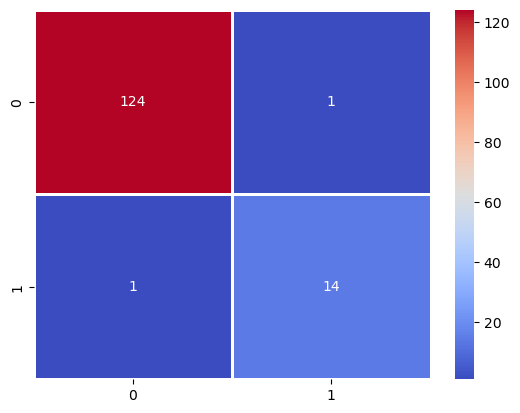

In [59]:
sns.heatmap(confusion_matrix(y_test, randomForestPred), cmap='coolwarm', annot=True, linewidth=1, fmt='d')
plt.show()

### Grid Search Para o Modelo de Randon Forest

In [60]:
# GRID SEARC PARA O RANDOM FOREST 
grid_space={'max_depth': [2,3,4,5],
            'min_samples_split': [50,100,200,300,500]}

gridRandomForest = GridSearchCV(model_randomForest,param_grid=grid_space,cv=3,scoring='accuracy')

gridRandomForest.fit(x_train, y_train)

print('Best hyperparameters are: '+str(gridRandomForest.best_params_))
print('Best score is: '+str(gridRandomForest.best_score_))

Best hyperparameters are: {'max_depth': 2, 'min_samples_split': 50}
Best score is: 0.9711525189786059


### Plot SHAP

In [61]:
import shap

# load JS visualization code to notebook
shap.initjs()

In [64]:
explainer_model_RandomForest = shap.TreeExplainer(model_randomForest)
shap_test_model_RandomForest = explainer_model_RandomForest.shap_values(x_test)

In [65]:
shap.force_plot(explainer_model_RandomForest.expected_value[1], shap_test_model_RandomForest[1][0,:], x_test.iloc[0,:])

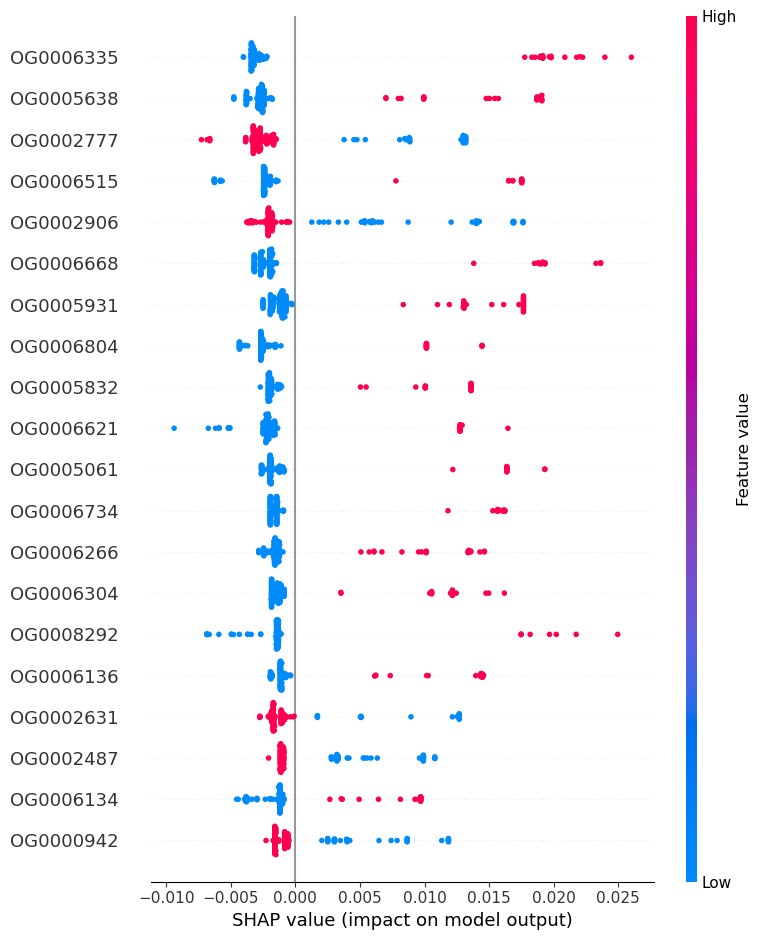

In [66]:
shap.summary_plot(shap_test_model_RandomForest[1], x_test)

In [67]:
# Verifica predição
# from xgboost import XGBClassifier
# from sklearn.model_selection import cross_val_score
# import pickle
# import warnings
from sklearn.model_selection import cross_val_score

scores = cross_val_score(model_randomForest, x, y, cv=10, scoring='accuracy')
scores.sort()
accuracy = scores.mean()
print(scores)
print(accuracy)


# # df_train = pd.read_csv("data/dataset.csv").sample(10000)
# xgb = XGBClassifier()
# xgb.fit(x, y)
# xgb_scores = cross_val_score(xgb, x, y, cv=10, scoring='roc_auc').mean()
# xgb_score = np.mean(xgb_scores)
# print("XGB - AUC (ROC): ", xgb_scores)

[0.94285714 0.97058824 0.97058824 0.97142857 0.97142857 0.97142857
 1.         1.         1.         1.        ]
0.9798319327731093
